In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import numpy.ma as ma
import matplotlib.colors as colors
from statistics import mode
import pandas as pd
from scipy import signal
from cartopy.util import add_cyclic_point

home_dir = '/glade/work/devond/'
import sys  
sys.path.insert(0, home_dir)

from functions import * 

crs_sp = ccrs.SouthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()

In [2]:
def get_seasonal_trends(data):
    mam, jja, son, djf = get_seasonal_data(data, 'mean')

    djf_trend, djf_p = calculate_trend(djf.values)
    mam_trend, mam_p = calculate_trend(mam.values)
    jja_trend, jja_p = calculate_trend(jja.values)
    son_trend, son_p = calculate_trend(son.values)

    djf_trend, lon2 = add_cyclic_point(djf_trend, coord=lon)
    mam_trend, lon2 = add_cyclic_point(mam_trend, coord=lon)
    jja_trend, lon2 = add_cyclic_point(jja_trend, coord=lon)
    son_trend, lon2 = add_cyclic_point(son_trend, coord=lon)
    djf_p, lon2 = add_cyclic_point(djf_p, coord=lon)
    mam_p, lon2 = add_cyclic_point(mam_p, coord=lon)
    jja_p, lon2 = add_cyclic_point(jja_p, coord=lon)
    son_p, lon2 = add_cyclic_point(son_p, coord=lon)

    djf_sig = np.copy(djf_trend)
    djf_sig[djf_p>0.05] = np.nan

    jja_sig = np.copy(jja_trend)
    jja_sig[jja_p>0.05] = np.nan

    mam_sig = np.copy(mam_trend)
    mam_sig[mam_p>0.05] = np.nan

    son_sig = np.copy(son_trend)
    son_sig[son_p>0.05] = np.nan
    
    return mam_trend, jja_trend, son_trend, djf_trend, [mam_sig, jja_sig, son_sig, djf_sig], lon2

In [3]:
### ----- Read ICE SHEET MASK data ----- ###
mask_file = '/glade/work/devond/AIS_masks/model_masks/CESM_masks.nc'
cesm_masks = xr.open_dataset(mask_file)
cesm_masks = cesm_masks.sel(lat = slice(-90,-30))

cesm_ism_r = cesm_masks.grounded_ism.values #full ice sheet
cesm_ism_r[cesm_ism_r>0] = 0
cesm_ism_r[np.isnan(cesm_ism_r)] = 1
cesm_ism_r[cesm_ism_r==0] = np.nan
#cesm_ism_r, lon2 = add_cyclic_point(cesm_ism_r, coord=lon)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


## Geopotential

In [4]:
### --- Geopotential --- ###
zg = xr.open_dataset(f'{home_dir}CESM/zg/CESM2_zg_hist2.nc')
zg = zg.isel(plev = 0).sel(time = slice('1979-01-01','2015-01-01')).mean(dim='ensemble')['zg']

lat = zg.lat.values
lon = zg.lon.values

In [5]:
mam_trend_zg, jja_trend_zg, son_trend_zg, djf_trend_zg, zg_sig, lon2 = get_seasonal_trends(zg*cesm_ism_r)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


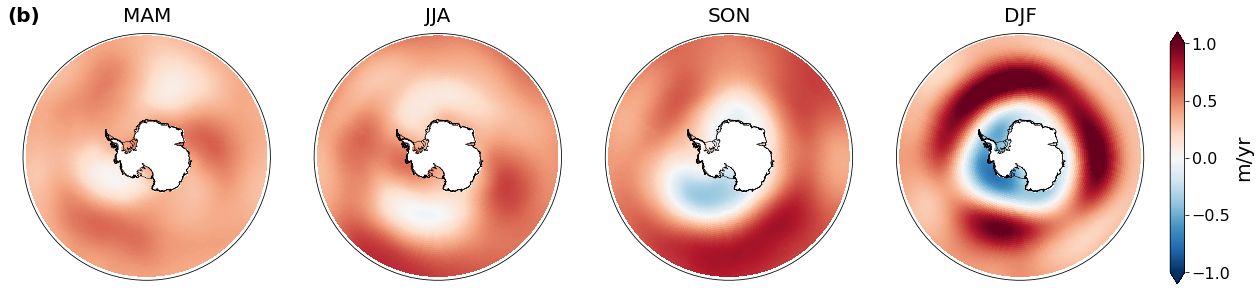

In [6]:
fig = plt.figure(figsize = (20,5))
gs=GridSpec(1,4)
plt.rcParams['axes.titlepad'] =14

ax1 = plt.subplot(gs[0,0],projection=crs_sp)
ax1.text(0.06, 1.12, '(b)', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax1.set_title('MAM', fontsize = 20)
ax2 = plt.subplot(gs[0,1],projection=crs_sp)
ax2.set_title('JJA', fontsize = 20)
ax3 = plt.subplot(gs[0,2],projection=crs_sp)
ax3.set_title('SON', fontsize = 20)
ax4 = plt.subplot(gs[0,3],projection=crs_sp)
ax4.set_title('DJF', fontsize = 20)
im = plot_seasonal_plots(lat, lon2, mam_trend_zg, jja_trend_zg, son_trend_zg, djf_trend_zg, 'RdBu_r', -1, 1, [ax1,ax2,ax3,ax4], -30)


cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, orientation = 'vertical', extend = 'both')
cb.set_label(label=f'm/yr', size=20)
cb.ax.tick_params(labelsize=16)
plt.savefig('geopotential_trends.png', dpi = 300, bbox_inches = 'tight')

## Wind speed

In [6]:
### --- Wind Speed --- ###
wind = xr.open_dataset('/glade/work/devond/CESM/wind/CESM2_U10_hist.nc')['U10'].mean(dim = 'ensemble')
wind = wind.sel(time = slice('1979-01-01', '2015-01-01'))

In [7]:
mam_trend_wind, jja_trend_wind, son_trend_wind, djf_trend_wind, wind_sig, lon2 = get_seasonal_trends(wind*cesm_ism_r)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


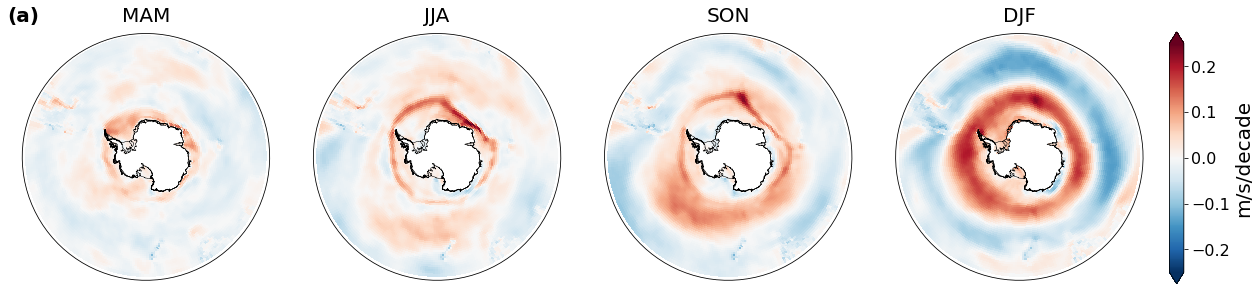

In [14]:
fig = plt.figure(figsize = (20,5))
gs=GridSpec(1,4)
plt.rcParams['axes.titlepad'] =14


ax1 = plt.subplot(gs[0,0],projection=crs_sp)
ax1.text(0.06, 1.12, '(a)', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax1.set_title('MAM', fontsize = 20)
ax2 = plt.subplot(gs[0,1],projection=crs_sp)
ax2.set_title('JJA', fontsize = 20)
ax3 = plt.subplot(gs[0,2],projection=crs_sp)
ax3.set_title('SON', fontsize = 20)
ax4 = plt.subplot(gs[0,3],projection=crs_sp)
ax4.set_title('DJF', fontsize = 20)
im = plot_seasonal_plots(lat, lon2, mam_trend_wind*10, jja_trend_wind*10, son_trend_wind*10, djf_trend_wind*10, 'RdBu_r', -0.25, 0.25, [ax1,ax2,ax3,ax4], -30)


cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, orientation = 'vertical', extend = 'both')
cb.set_label(label=f'm/s/decade', size=20)
cb.ax.tick_params(labelsize=16)
plt.savefig('windspeed_trends.png', dpi = 300, bbox_inches = 'tight')

## Sea level pressure

In [8]:
### --- Sea Level Pressure --- ###
slp = xr.open_dataset('/glade/work/devond/CESM/sea_level_pressure/CESM2_PSL_hist.nc').mean(dim = 'ensemble')
slp = slp.sel(time = slice('1979-01-01', '2015-01-01'))['PSL']/100

In [9]:
mam_trend_slp, jja_trend_slp, son_trend_slp, djf_trend_slp, slp_sig, lon2 = get_seasonal_trends(slp*cesm_ism_r)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


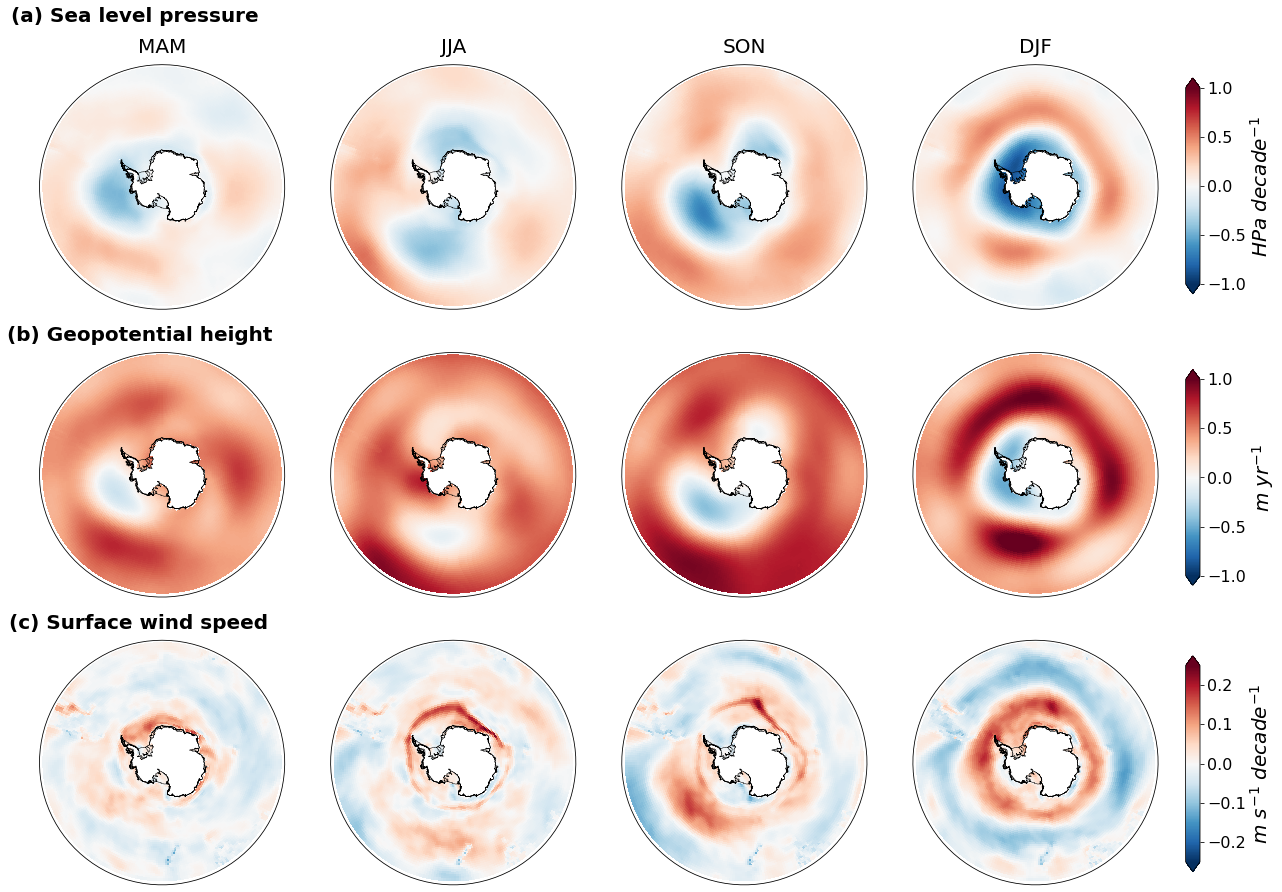

In [10]:
fig = plt.figure(figsize = (20,15))
gs=GridSpec(3,4)
plt.rcParams['axes.titlepad'] =14

ax1 = plt.subplot(gs[0,0],projection=crs_sp)
ax1.set_title('MAM', fontsize = 20)
ax2 = plt.subplot(gs[0,1],projection=crs_sp)
ax2.set_title('JJA', fontsize = 20)
ax3 = plt.subplot(gs[0,2],projection=crs_sp)
ax3.set_title('SON', fontsize = 20)
ax4 = plt.subplot(gs[0,3],projection=crs_sp)
ax4.set_title('DJF', fontsize = 20)
im = plot_seasonal_plots(lat, lon2, mam_trend_slp*10, jja_trend_slp*10, son_trend_slp*10, djf_trend_slp*10, 'RdBu_r', -1, 1, [ax1,ax2,ax3,ax4], -30)
ax1.text(0.9, 1.25, '(a) Sea level pressure', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

cbar_ax = fig.add_axes([0.92, 0.67, 0.01, 0.2])
cb = fig.colorbar(im, cax=cbar_ax, orientation = 'vertical', extend = 'both')
cb.set_label(label='$HPa~decade^{-1}$', size=20)
cb.ax.tick_params(labelsize=16)

ax5 = plt.subplot(gs[1,0],projection=crs_sp)
ax6 = plt.subplot(gs[1,1],projection=crs_sp)
ax7 = plt.subplot(gs[1,2],projection=crs_sp)
ax8 = plt.subplot(gs[1,3],projection=crs_sp)
im = plot_seasonal_plots(lat, lon2, mam_trend_zg, jja_trend_zg, son_trend_zg, djf_trend_zg, 'RdBu_r', -1, 1, [ax5,ax6,ax7,ax8], -30)
ax5.text(0.96, 1.12, '(b) Geopotential height', transform=ax5.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

cbar_ax = fig.add_axes([0.92, 0.4, 0.01, 0.2])
cb = fig.colorbar(im, cax=cbar_ax, orientation = 'vertical', extend = 'both')
cb.set_label(label='$m~yr^{-1}$', size=20)
cb.ax.tick_params(labelsize=16)

ax9 = plt.subplot(gs[2,0],projection=crs_sp)
ax10 = plt.subplot(gs[2,1],projection=crs_sp)
ax11 = plt.subplot(gs[2,2],projection=crs_sp)
ax12 = plt.subplot(gs[2,3],projection=crs_sp)
im = plot_seasonal_plots(lat, lon2, mam_trend_wind*10, jja_trend_wind*10, son_trend_wind*10, djf_trend_wind*10, 'RdBu_r', -0.25, 0.25, [ax9,ax10,ax11,ax12], -30)
ax9.text(0.94, 1.12, '(c) Surface wind speed', transform=ax9.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

cbar_ax = fig.add_axes([0.92, 0.135, 0.01, 0.2])
cb = fig.colorbar(im, cax=cbar_ax, orientation = 'vertical', extend = 'both')
cb.set_label(label='$m~s^{-1}~decade^{-1}$', size=20)
cb.ax.tick_params(labelsize=16)

plt.savefig('SAM.png', dpi = 300, bbox_inches = 'tight')